In [1]:
import sqlite3
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

pandas.options.mode.copy_on_write = True

conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select avg(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration, data_time.date, attendances from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'concentration', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])

# scale
scaler = StandardScaler()
data[['concentration']] = scaler.fit_transform(data[['concentration']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

,commune,concentration,date,attendances
date,,,,
2018-01-01,LA CISTERNA,0.318082,2018-01-01,0.284231
2018-01-01,PENALOLEN,-1.227433,2018-01-01,0.608272
2018-01-01,PUENTE ALTO,0.839011,2018-01-01,2.636857
2018-01-01,TALAGANTE,-1.602993,2018-01-01,-1.183570
2018-02-01,LA CISTERNA,-1.384115,2018-02-01,-0.686412
...,...,...,...,...
2024-04-01,LA CISTERNA,1.280945,2024-04-01,1.053643
2024-04-01,PENALOLEN,0.998143,2024-04-01,0.130349
2024-05-01,PENALOLEN,1.432024,2024-05-01,-0.038922


      commune  concentration        date  attendances  time_step
0   PENALOLEN      -1.227433  2018-01-01     0.608272          0
1   PENALOLEN      -0.623476  2018-02-01    -0.457068          1
2   PENALOLEN      -0.368252  2018-03-01     0.492860          2
3   PENALOLEN      -0.102736  2018-04-01     0.839096          3
4   PENALOLEN       0.552652  2018-05-01     0.568322          4
..        ...            ...         ...          ...        ...
62  PENALOLEN       0.022412  2024-02-01    -0.291841         62
63  PENALOLEN       0.733530  2024-03-01    -0.721923         63
64  PENALOLEN       0.998143  2024-04-01     0.130349         64
65  PENALOLEN       1.432024  2024-05-01    -0.038922         65
66  PENALOLEN       1.193275  2024-06-01    -0.266194         66

[67 rows x 5 columns]
RMSE: 1.1022951071189397


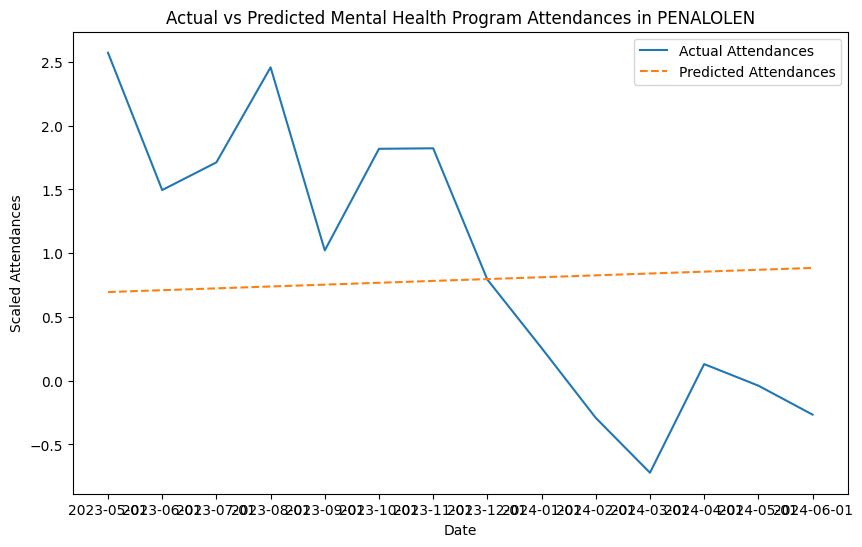

In [ ]:
A = data[data['commune'] == 'PENALOLEN']

# add index
A = A.reset_index(drop=True)
A['time_step'] = A.index
print(A)

A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(A_train[['time_step']], A_train['attendances'])
A_pred = model.predict(A_test[['time_step']])

rmse = root_mean_squared_error(A_test['attendances'], A_pred)
print(f'RMSE: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(A_test['date'], A_test['attendances'], label='Actual Attendances')
plt.plot(A_test['date'], A_pred, label='Predicted Attendances', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Scaled Attendances')
plt.title('Actual vs Predicted Mental Health Program Attendances in PENALOLEN')
plt.legend()
plt.show()
